### Introduction

Here, we apply the SCR methods to one real fMRI dataset of 3D contrast maps from multiple people.  

**The Task**

In the experiment, 78 unrelated subjects performed two tasks spread across two runs where each run contained four blocks. During each block, the subject undertook either a 2-back memory task or a 0-back control task. The experimental design was arranged such that, in each run, two blocks were designated to the 2-back memory task, and two blocks were designated to the 0-back control task. In each block a subject was shown a stimuli image (a picture of a face or a place, for instance) and then asked to recall the image they were shown. They were either asked to recall the most recent image (the '0-back' image) or the image shown to them two images prior (the '2-back' image). 


**First-level Analysis**

In FSL, a first-level analysis has been conducted independently for each subject. In each first-level analysis, the task design was regressed onto Blood Oxygenation Level Dependent (BOLD) response and a Contrast Parameter Estimate (COPE) map was generated. Each COPE map represents, for a given subject, the difference in BOLD response between the subject performing the 2-back task and the 0-back task (e.g $L\hat{\beta}=\hat{\beta}_{\text{2-Back}}-\hat{\beta}_{\text{0-Back}})$).


**Acquisition Details**

All image acquisitions were obtained using a $32$ channel head coil on a modified $3T$ Siemans Skyra scanner via a gradient-echo EPI sequence with TR $=720$ ms, TE $=33.1$ ms, $2.0$ mm slice thickness, $72$ slices, $2.0$ mm isotropic voxels, $208$ mm $\times 180$ mm FOV, and a multi-band acceleration factor of $8$.

 
For more information on these variables, please visit [this link](https://wiki.humanconnectome.org/display/PublicData/HCP-YA+Data+Dictionary-+Updated+for+the+1200+Subject+Release). 


In [2]:
import os
import numpy as np
import numpy.matlib as npm
import matplotlib.pyplot as plt 
from nilearn.plotting import plot_img, plot_stat_map, view_img
from nilearn.image import get_data, load_img

### Data Import 

We first import the data, which were previously downloaded into the folder. 


In [3]:
# Real data directory
data_dir = os.path.join(os.getcwd(),'data')
real_data_dir = os.path.join(os.getcwd(),'data','hcp78')
data_loc = real_data_dir + '\\WM\\'
bold_files_total = os.listdir(data_loc)
bold_files = [os.path.join(data_loc, file) for file in bold_files_total]

In [4]:
print('number of BOLD files:', len(bold_files))

number of BOLD files: 78


First we apply the MNI mask, which will reduce the image size and focus only on areas in the brain and apply some smoothing.

the shape of the MNI mask: (91, 109, 91)
number of voxels inside the MNI mask: 228483


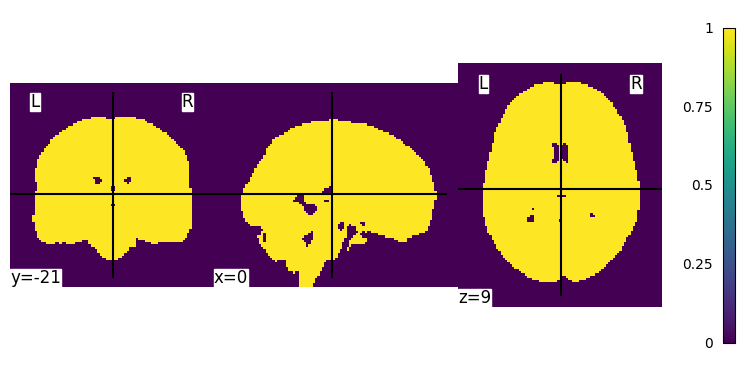

In [5]:
mask = data_dir + '\\MNImask.nii' #MNI mask 
plot_img(mask, cmap = 'viridis')
print("the shape of the MNI mask:", get_data(mask).shape)
print("number of voxels inside the MNI mask:", np.sum(get_data(mask)))

In [ ]:
from nilearn.maskers import NiftiMasker
fwhm = 5 # Set the smoothness parameter (in mm)

# this creates a NiftiMasker class, if mask_img is not prvided, will compute the mask in the fit step
masker = NiftiMasker(smoothing_fwhm=fwhm, mask_img=mask).fit()
data = masker.transform(bold_files).transpose()
print(data.shape)

(228483, 78)


### Confidence Set Construction

Now we construct confidence sets by inverting the SCB from bootstrap. Based on the simulation results, we use t-bootstrap with rademacher multilpliers. This is done on the masked data of shape (228483*78). 

In [7]:
from SimuInf import scb, confset
from SimuInf.plotting import confset_plot, ls_plot
est, lower, upper, q = scb.confband(data, m_boots=1000, print_q=True, return_q=True)

0.05th upper quantile of the distribution of the maximum of the random field:5.096,computed from multiplier bootstrap with res, t standardization and r multiplier


In [8]:
# construct confidence sets based on a list of thresholds
threshold_ls = 1+np.arange(10)
set_masked_ls = [list(confset.confset(est, lower, upper, threshold=threshold)) for threshold in threshold_ls]
#len(set_masked_ls)

In [9]:
# unmask to transform to 3d, this returns a list of Nifti1Imagec
set_unmasked_img_ls = [[masker.inverse_transform(set) for set in set_ls] for set_ls in set_masked_ls]
set_unmasked_ls = [[get_data(set) for set in img_ls] for img_ls in set_unmasked_img_ls]

In [10]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import Normalize

(91, 109, 91)


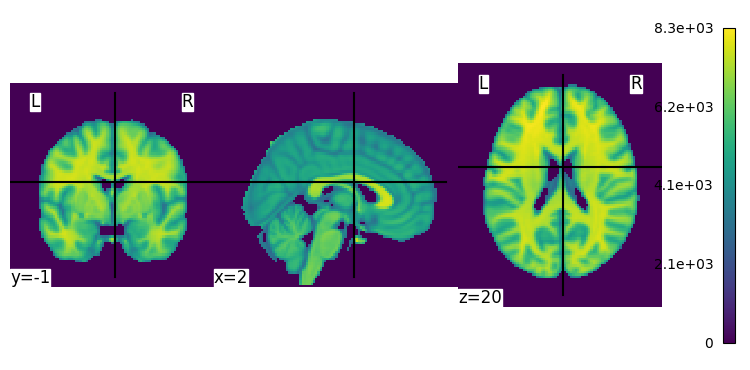

In [11]:
brain =  data_dir + '\\MNIbrain.nii.gz'
plot_img(brain, colorbar=True, cmap = 'viridis')
brain_array = get_data(brain)
print(brain_array.shape)

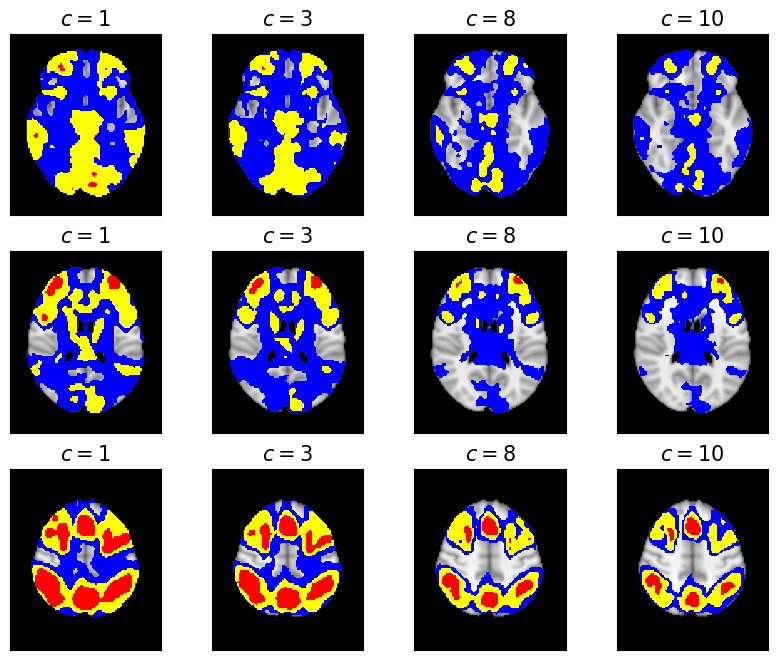

In [12]:
# visualize some results 
name_ls = [f'$c={i}$' for i in threshold_ls]
set_unmasked_ls_selected = list(np.array(set_unmasked_ls)[[0,2,7,9]])
name_ls_selected = list(np.array(name_ls)[[0,2,7,9]])
confset_plot(set_unmasked_ls_selected, name_ls_selected, nrow=3, figsize=(10,8), fontsize=15, background =brain, cuts = [30,45,60], ticks=False)

### Shiny App for Interactive Visualization
To build the Shiny app and explore the results interactively, save the outputs from the previous step into the `volume_app/` folder as shown below, and then run `volumn_app/app.py`. 

In [ ]:
import joblib
joblib.dump(masker, 'volume_app/hcp/masker')
joblib.dump(est, 'volume_app/hcp/est')
joblib.dump(lower, 'volume_app/hcp/lower')
joblib.dump(upper, 'volume_app/hcp/upper')
joblib.dump(brain, 'volume_app/hcp/brain')